In [46]:
require 'cutorch'
require 'cunn'

require 'nn';
require 'model';
require 'mnist_loader';


use_gpu = true

if use_cuda then
  Tensor = torch.CudaTensor
else
  Tensor = torch.Tensor
end

learningRate = 1e-1

G, D = get_model()
if use_gpu then
    G = G:cuda()
    D = D:cuda()
end

criterion = nn.ClassNLLCriterion()
if use_gpu then
    criterion = criterion:cuda()
end

In [47]:
train_set = mnist.loadTrainSet()

<mnist> done	


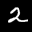

0	


In [48]:
displayData = train_set[1][1]
itorch.image(displayData)

print(train_set[1][2][9])

In [49]:
counter = 0
batchsize = 1

D_parameters, D_gradParameters = D:getParameters()
G_parameters, G_gradParameters = G:getParameters()

5000	
real D:1.822039604187	
real D:1.822039604187	
fake D:1.3351440429688e-05	
fake D:1.3351440429688e-05	
G make loss: 1.3351440429688e-05	


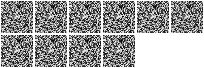

10000	
real D:1.8851698637009	
real D:1.8851698637009	
fake D:5.7220458984375e-06	
fake D:5.7220458984375e-06	
G make loss: 5.7220458984375e-06	


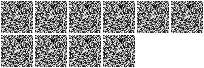

15000	
real D:2.2572221755981	
real D:2.2572221755981	
fake D:1.9073486328125e-06	
fake D:1.9073486328125e-06	
G make loss: 1.9073486328125e-06	


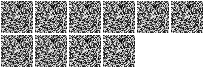

20000	
real D:2.1026251316071	
real D:2.1026251316071	
fake D:2.3841857910156e-06	
fake D:2.3841857910156e-06	
G make loss: 2.3841857910156e-06	


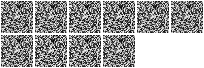

25000	
real D:2.1090579032898	
real D:2.1090579032898	
fake D:1.4305114746094e-06	
fake D:1.4305114746094e-06	
G make loss: 1.4305114746094e-06	


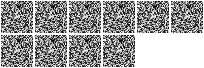

30000	
real D:2.7811055183411	
real D:2.7811055183411	
fake D:1.9073486328125e-06	
fake D:1.9073486328125e-06	
G make loss: 1.9073486328125e-06	


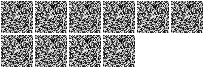

35000	
real D:2.2694573402405	
real D:2.2694573402405	
fake D:1.4305114746094e-06	
fake D:1.4305114746094e-06	
G make loss: 1.4305114746094e-06	


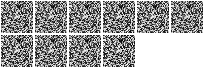

40000	
real D:3.0884025096893	
real D:3.0884025096893	
fake D:1.4305114746094e-06	
fake D:1.4305114746094e-06	
G make loss: 1.4305114746094e-06	


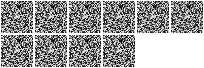

45000	
real D:1.7078373432159	
real D:1.7078373432159	
fake D:1.4305114746094e-06	
fake D:1.4305114746094e-06	
G make loss: 1.4305114746094e-06	


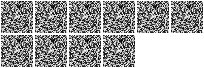

50000	
real D:2.6910367012024	
real D:2.6910367012024	
fake D:9.5367431640625e-07	
fake D:9.5367431640625e-07	
G make loss: 9.5367431640625e-07	


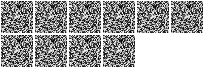

55000	
real D:2.0217561721802	
real D:2.0217561721802	
fake D:9.5367431640625e-07	
fake D:9.5367431640625e-07	
G make loss: 9.5367431640625e-07	


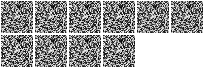

60000	
real D:2.3569445610046	
real D:2.3569445610046	
fake D:4.7683715820312e-07	
fake D:4.7683715820312e-07	
G make loss: 4.7683715820312e-07	


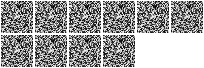

In [50]:
for j=1, 1 do
    train_set:shuffle()
    for batch_count = 1, train_set:size() / batchsize do
        D_gradParameters:zero()
        G_gradParameters:zero()
        
        local D_real_error1 = 0
        local D_real_error2 = 0
        local D_fake_error1 = 0
        local D_fake_error2 = 0
        local G_error = 0
        local G_gradParameters_batch = G_gradParameters:clone():zero()
        local D_gradParameters_batch = D_gradParameters:clone():zero()
        
                       
        
        for batch_count_idx = 1, batchsize do
            i = (batch_count - 1) * batchsize + batch_count_idx

            -- update D
            inputImgInput = train_set[i][1]:view(32, 32):cuda()
            inputVectorInput = train_set[i][2]:cuda()

            real_pred = D:forward({inputImgInput, inputVectorInput})
            real_target = 1
            local real_D_loss_1 = criterion:forward(real_pred, real_target)
            
            D_real_error1 = D_real_error1 + real_D_loss_1

            D:zeroGradParameters()                        

            local t = criterion:backward(real_pred, real_target)
            D:backward({inputImgInput, inputVectorInput}, t)
            
            
            -- add gradParameters
            D_gradParameters_batch = D_gradParameters_batch + D_gradParameters
            


            real_pred = D:forward({inputImgInput, inputVectorInput})
            local real_D_loss_2 = criterion:forward(real_pred, real_target)


            -- fake image

            noise = torch.randn(100)
            if use_gpu then
                noise = noise:cuda()
            end

            fake_img = G:forward({noise, inputVectorInput})
            fake_pred = D:forward({fake_img, inputVectorInput})
            fake_target = 2

            local fake_D_loss_1 = criterion:forward(fake_pred, fake_target)

            D:zeroGradParameters()

            local t = criterion:backward(fake_pred, fake_target)
            local fake_img_prime = D:backward({fake_img, inputVectorInput}, t)
            
            -- add gradParameters
            D_gradParameters_batch = D_gradParameters_batch + D_gradParameters
            

            fake_pred = D:forward({fake_img, inputVectorInput})
            local fake_D_loss_2 = criterion:forward(fake_pred, fake_target)

            -- for generator
            G:zeroGradParameters()
            G:backward({noise, inputVectorInput}, fake_img_prime[1])
            
            -- add gradParameters
            G_gradParameters_batch = G_gradParameters_batch + G_gradParameters

            new_fake_img = G:forward({noise, inputVectorInput})
            new_fake_pred = D:forward({new_fake_img, inputVectorInput})
            local G_D_loss = criterion:forward(new_fake_pred, fake_target)

            counter = counter + 1
            if counter % 5000 == 0 then
                print(counter)
                print("real D:" .. real_D_loss_1)
                print("real D:" .. real_D_loss_2)
                print("fake D:" .. fake_D_loss_1)    
                print("fake D:" .. fake_D_loss_2)
                print("G make loss: " .. G_D_loss)    

                res = torch.zeros(10, 32, 32)
                labelVector = torch.zeros(10)

                if use_gpu then
                    res = res:cuda()
                    labelVector = labelVector:cuda()
                end


                for m=1, 10 do
                    local noiseInput = torch.randn(100)
                    if use_gpu then
                        noiseInput = noiseInput:cuda()
                    end
                    labelVector:zero()
                    labelVector[m] = 1
                    local genImg = G:forward({noiseInput, labelVector})
                    res[{m, {}, {}}] = genImg
                end
                itorch.image(res)
            end
        end
         -- if x% changes to update D
        randnum = torch.random(1, 5)
        
        if randnum == 1 then
            D_gradParameters = D_gradParameters_batch / (2 * batchsize)
            D:updateParameters(learningRate)
        end
        
        G_gradParameters = G_gradParameters_batch / batchsize
        G:updateParameters(learningRate*10)        
    end
end